In [1]:
import pymc as pm
import numpy as np
import arviz as az
from itertools import combinations

%load_ext lab_black
%load_ext watermark

# Coagulation

An example of Bayesian ANOVA.

Adapted from [unit 7: anovacoagulation.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/anovacoagulation.odc).

The first lecture uses fat1.odc, but that file wasn't provided. You can see the code in the Lesson 11 video, though. It just uses the X8 predictor.

Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/fat.tsv).

## Associated lecture video: Unit 7 Lecture 7

In [2]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed?v=xomK4tcePmc&list=PLv0FeK5oXK4l-RdT6DWJj0_upJOG2WKNO&index=69" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

## Problem statement

Here 24 animals are randomly allocated to 4 different diets,  but the numbers allocated to different diets are not the same. The coagulation time for blood is measured for each animal. Are the diet-based differences significant?



[Box, Hunter, Hunter; Statistics for Experimenters, p. 166](https://pages.stat.wisc.edu/~yxu/Teaching/16%20spring%20Stat602/%5bGeorge_E._P._Box,_J._Stuart_Hunter,_William_G._Hu(BookZZ.org).pdf)

In [3]:
# cut and pasted data from .odc file
# fmt: off
times = (62, 60, 63, 59, 63, 67, 71, 64, 65, 66, 68, 66, 71, 67, 68, 68, 56, 62,
         60, 61, 63, 64, 63, 59)
diets = (1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4)
# fmt: on

# create dictionary where each key is a diet and values are lists of times
data = {}
for key, val in zip(diets, times):
    data.setdefault(key, []).append(val)
data

{1: [62, 60, 63, 59],
 2: [63, 67, 71, 64, 65, 66],
 3: [68, 66, 71, 67, 68, 68],
 4: [56, 62, 60, 61, 63, 64, 63, 59]}

## Simple method

No loops! If you're using this style, 4 treatments is probably the max before it starts to get too annoying to type out.

In [4]:
with pm.Model() as m:
    mu0 = pm.Normal("μ0", mu=0, tau=0.0001)
    tau = pm.Gamma("τ", 0.001, 0.001)

    alpha4 = pm.Normal("α4", mu=0, tau=0.0001)
    alpha3 = pm.Normal("α3", mu=0, tau=0.0001)
    alpha2 = pm.Normal("α2", mu=0, tau=0.0001)
    # sum-to-zero constraint
    alpha1 = pm.Deterministic("α1", -(alpha2 + alpha3 + alpha4))

    mu_1 = mu0 + alpha1
    mu_2 = mu0 + alpha2
    mu_3 = mu0 + alpha3
    mu_4 = mu0 + alpha4

    pm.Normal("lik1", mu=mu_1, tau=tau, observed=data[1])
    pm.Normal("lik2", mu=mu_2, tau=tau, observed=data[2])
    pm.Normal("lik3", mu=mu_3, tau=tau, observed=data[3])
    pm.Normal("lik4", mu=mu_4, tau=tau, observed=data[4])

    onetwo = pm.Deterministic("α1-α2", alpha1 - alpha2)
    onethree = pm.Deterministic("α1-α3", alpha1 - alpha3)
    onefour = pm.Deterministic("α1-α4", alpha1 - alpha4)
    twothree = pm.Deterministic("α2-α3", alpha2 - alpha3)
    twofour = pm.Deterministic("α2-α4", alpha2 - alpha4)
    threefour = pm.Deterministic("α3-α4", alpha3 - alpha4)

    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ0, τ, α4, α3, α2]


/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8802, but should be close to 0.8. Try to increase the number of tunin

In [5]:
az.summary(trace, var_names=["α"], filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
α4,-3.004,0.803,-4.567,-1.520
α3,4.002,0.885,2.368,5.688
α2,1.997,0.886,0.335,3.687
α1,-2.995,1.019,-4.918,-1.066
α1-α2,-4.992,1.598,-8.007,-1.971
α1-α3,-6.997,1.603,-10.061,-4.015
α1-α4,0.009,1.511,-2.881,2.847
α2-α3,-2.005,1.433,-4.746,0.706
α2-α4,5.001,1.337,2.441,7.511
α3-α4,7.006,1.328,4.528,9.548


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

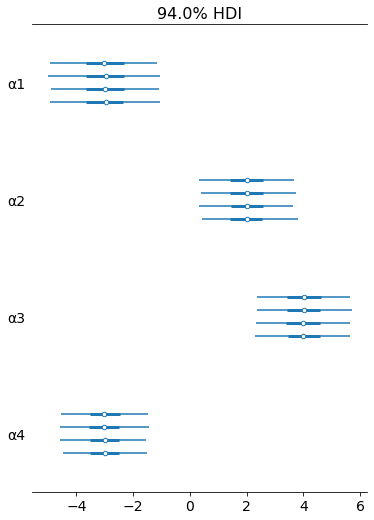

In [6]:
az.plot_forest(trace, var_names=["α1", "α2", "α3", "α4"])

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

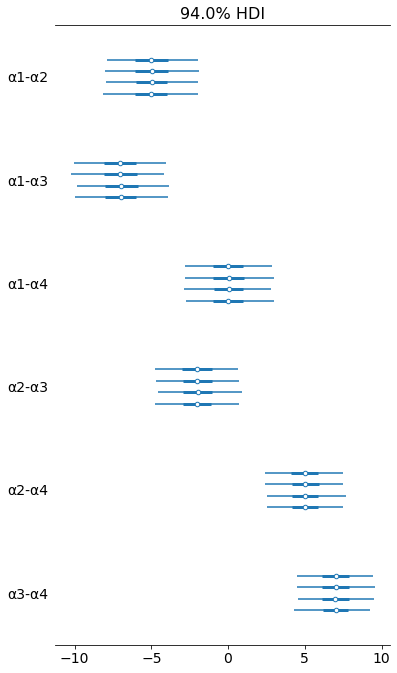

In [7]:
az.plot_forest(trace, var_names=["~τ", "~μ0", "~α1", "~α2", "~α3", "~α4"])

## A more concise method
Not necessarily pretty, but easier to extend to more treatments. I'm interested in seeing other peoples' methods here; I feel like this could still be a lot cleaner.

In [8]:
# get possible combinations
combos = list(combinations(range(4), 2))
combos

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [9]:
with pm.Model() as m:
    mu0 = pm.Normal("μ0", mu=0, tau=0.0001)
    tau = pm.Gamma("τ", 0.001, 0.001)

    alphas = [pm.Normal(f"α{i}", mu=0, tau=0.0001) for i in range(2, 5)]

    # sum-to-zero constraint
    alphas.insert(0, pm.Deterministic("α1", -(alphas[0] + alphas[1] + alphas[2])))

    mus = [
        pm.Deterministic(f"mu{i + 1}", mu0 + alpha) for i, alpha in enumerate(alphas)
    ]

    likelihoods = [
        pm.Normal(f"lik{i + 1}", mu=mus[i], tau=tau, observed=data[i + 1])
        for i, mu in enumerate(mus)
    ]

    [pm.Deterministic(f"α{i + 1} - α{j + 1}", alphas[i] - alphas[j]) for i, j in combos]

    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/pymc/aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ0, τ, α2, α3, α4]


/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/aaron/mambaforge/envs/pymc_env/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.


In [10]:
az.summary(trace, var_names=["α"], filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
α2,2.002,0.889,0.378,3.746
α3,3.997,0.889,2.333,5.680
α4,-3.005,0.814,-4.552,-1.467
α1,-2.994,1.014,-4.883,-1.057
α1 - α2,-4.997,1.593,-7.949,-1.910
α1 - α3,-6.991,1.598,-9.998,-3.986
α1 - α4,0.010,1.513,-2.891,2.824
α2 - α3,-1.995,1.440,-4.705,0.749
α2 - α4,5.007,1.351,2.477,7.555
α3 - α4,7.002,1.345,4.500,9.541


In [11]:
%watermark --iversions -v

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

numpy : 1.22.3
pymc  : 4.0.0b5
arviz : 0.12.1
pandas: 1.4.2

